In [ ]:
!pip install qiskit torch torchvision matplotlib
!pip install qiskit-machine-learning
!pip install torchviz

!pip install qiskit[all]
!pip install qiskit == 0.45.2
!pip install qiskit_algorithms == 0.7.1
!pip install qiskit-ibm-runtime == 0.17.0
!pip install qiskit-aer == 0.13.2

#Quentum net draw
!pip install pylatexenc

In [ ]:
# PyTorch
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import Module, Conv2d, Linear, Dropout2d, CrossEntropyLoss
import torch.nn.functional as F
from torchviz import make_dot
from torch import Tensor
from torch import cat

In [ ]:
# Qiskit
from qiskit import Aer
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks.estimator_qnn import EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Visualization
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Folder direction
train_data = datasets.ImageFolder('/content/drive/MyDrive/QCNN/Data-set/Train', transform=transforms.Compose([transforms.ToTensor()]))
test_data = datasets.ImageFolder('/content/drive/MyDrive/QCNN/Data-set/Test', transform=transforms.Compose([transforms.ToTensor()]))

In [ ]:
#e train and test Tensor size
print(f"Data tensor Dimension:",train_data[0][0].shape)

Data tensor Dimension: torch.Size([3, 432, 432])


In [ ]:
#Convert to DataLoader
train_loader = DataLoader(train_data, shuffle=True, batch_size=1)
test_loader = DataLoader(test_data, shuffle=True, batch_size=1)

In [ ]:
#Show the labels
print((train_loader.dataset.class_to_idx))

{'anthro': 0, 'bio': 1}


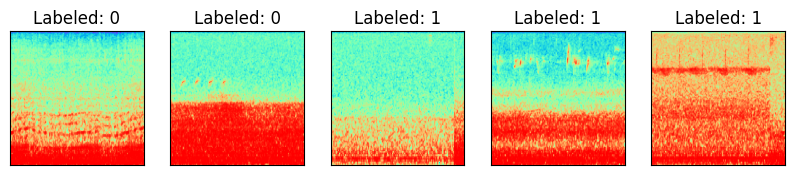

In [ ]:
n_samples_show = 5

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 10))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap=plt.cm.rainbow)
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title(f"Labeled: {targets[0].item()}")

    n_samples_show -= 1

In [ ]:
# batch size
batch_size = 10

In [ ]:
# Quantum Neural Networ model
def create_qnn():
    qnn_circuit = QNNCircuit(2)
    qnn = EstimatorQNN(circuit=qnn_circuit)
    return qnn

qnn = create_qnn()
print(qnn.circuit)

     ┌──────────────────────────┐»
q_0: ┤0                         ├»
     │  ZZFeatureMap(x[0],x[1]) │»
q_1: ┤1                         ├»
     └──────────────────────────┘»
«     ┌──────────────────────────────────────────────────────────┐
«q_0: ┤0                                                         ├
«     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
«q_1: ┤1                                                         ├
«     └──────────────────────────────────────────────────────────┘


In [ ]:
# Calcular dinámicamente el tamaño de entrada para fc1
def get_conv_output_size(model, shape):
    batch_size = 1
    input = torch.autograd.Variable(torch.rand(batch_size, *shape))
    output_feat = model._forward_features(input)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size

In [ ]:
#Definimos red neuronal en PyTorch
class Net(Module):
    def __init__(self, qnn):
        super(Net, self).__init__()
        self.conv1 = Conv2d(3, 24, kernel_size=5)
        self.conv2 = Conv2d(24, 48, kernel_size=5)
        self.dropout = Dropout2d()
        # Calcular dinámicamente el tamaño de entrada para fc1
        #self.conv_output_size = self._get_conv_output_size((3, 432, 432))
        self.fc1 = Linear(529200, 512)  # Reducir el número de neuronas en fc1
        self.fc2 = Linear(512, 2)  # Salida 2 para dos clases
        self.qnn = TorchConnector(qnn)
        self.fc3 = Linear(1, 1)  # Salida 2 para dos clases

    def _get_conv_output_size(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        print("Tamaño calculado:", n_size)
        return n_size

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # Aplicamos la red cuántica nuevamente en la sección forward
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

In [ ]:
# Crea una instancia del modelo
model = Net(qnn)

In [ ]:
# Imprimir el modelo
print(model)

Net(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=529200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)


In [ ]:
print(f"Device: {next(model.parameters()).device}")

Device: cpu


In [ ]:
#dummy_tensor = next(iter(train_loader))[0].to('cuda')
dummy_tensor = next(iter(train_loader))[0]
output = model(dummy_tensor)
params = dict(list(model.named_parameters()))

# Concatenamos los tensores utilizando torch.cat en lugar de cat
concatenated_output = torch.cat((output, 1 - output), -1)

make_dot(concatenated_output, params=params).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

In [ ]:
# Definimos optimizador y función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss()

# Empezamos entrenamiento
epochs = 3  # Número de épocas
loss_list = []
model.train() # Modelo en modo entrenamiento

for epoch in range(epochs):
    correct = 0
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Se inicializa gradiente
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()  # Backward pass
        optimizer.step()  # Optimizamos pesos
        total_loss.append(loss.item())  # Cálculo de la función de pérdida
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / len(train_loader) #Cálculo de precisión
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%")

KeyboardInterrupt: 